# Eliminación de Anomalías de una Imágen

## RafaCastle

## Importando librerías

In [1]:
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

## Definiendo variables

Para escoger una imagen solo hace falta escribir el número correspondiente en la variable *numero_imagen*  y tener todas las imágenes que se subieron a la plataforma en la misma carpeta que este notebook. Las imágenes son mostradas en el PDF adjunto.

Imagen escogida: Imagen 2


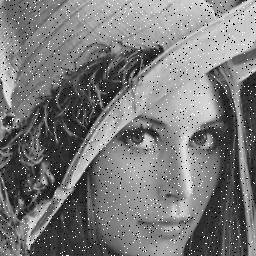

In [2]:
numero_imagen = 2
imagen_original = Image.open(f'Imagen{numero_imagen}.png')
print(f'Imagen escogida: Imagen {numero_imagen}')
display(imagen_original)

Algunas líneas de la siguiente celda se tomaron del notebook visto en clase el 5 de diciembre del 2022. Se guardan

- Las dimensiones de la imágen: Los pixeles a lo ancho y alto
- Los pixeles: El valor numérico de cada pixel en un arreglo, a la variable pixeles se le puede asociar un arreglo $f$ que puede interpretarse como una matriz de dimensión $M \times N$ o como un tensor $T$ de dimensión $M \times N \times 3$. Para una imagen en blanco y negro cada una de las 3 matrices en el tensor $T$ es exactamente igual, es decir si $T=[M_1,M_2,M_3]$ con $M_i$ matrices de dimensión $M\times N$ para $i=1,2,3$ entonces $M_1=M_2=M_3$. El presente código puede trabajar con ambos tipos de imágenes, separándolas en 2 casos. 
- El caso de la imágen: El caso 1 es para las imágenes donde la variable pixeles es de la forma $M \times N \times 3$ y el caso 0 para las que es de la forma $M \times N$.
- Las dimensiones del filtro: Los pixeles a lo ancho $n$ y alto $m$

In [3]:
# dimensiones de la imágen
ancho, alto = imagen_original.size

# pixeles
pixeles = imagen_original.load()
matriz_asociada = np.array(imagen_original)

# caso de la imagen 
caso = 1 if len(matriz_asociada.shape) == 3 else 0

# dimensiones del filtro, tomar siempre números pares
m = 4 
n = 4 

## Detección de las anomalías

En la siguiente celda detectaremos los pixeles que posiblemente son *anómalos* en la imagen. El concepto de anomalías para este código, junto con la descripción detallada del método de detección de éstas, están definidos en el PDF adjunto. 

In [4]:
# para obtener el tiempo en el que se realiza el cálculo
start_time = time.time()

# lista de posibles anomalías
posibles_anomalias = []

# se toman esos límites del for para que el filtro no se salga de la imagen
for y in range(m//2,alto-m//2+1):
    for x in range(n//2,ancho-n//2+1):
        
        # cascarón del filtro de dimensión mxn (todos los valores son 0)
        filtro = np.zeros((m,n),dtype=int)
        
        # r1 recorrerá los pixeles de forma horizontal en el filtro
        r1=0
        
        for r in range(-m//2,m//2):
            
            # c1 recorrerá los pixeles de forma vertical en el filtro
            c1=0
            
            # c y r son equivalentes a c1 y r1, la diferencia es que estos últimos parten de 0 y no de valores negativos
            for c in range(-n//2,n//2):
                
                # toma solo pixeles dentro de la imagen 
                if (y+r>=0 and y+r<=alto and x+c>=0  and x+c<=ancho):
                    
                    # se actualizan los valores del filtro
                    filtro[r1,c1] = pixeles[x+c,y+r][0] if caso == 1 else pixeles[x+c,y+r]
                c1+=1
            r1+=1
            
        # promedio y desviación
        media = filtro.mean()
        desviacion = filtro.std()
         
        for r in range(-m//2,m//2):
            for c in range(-n//2,n//2):
                if (y+r>=0 and y+r<=alto and x+c>=0  and x+c<=ancho):
                    pixel = pixeles[x+c,y+r][0] if caso==1 else pixeles[x+c,y+r]
                    
                    # analiza si el pixel es una posible anomalía
                    if pixel not in range(int(media-2*desviacion) , math.ceil(media+2*desviacion)+1):
                        posibles_anomalias.append([x+c,y+r,media])

print('Detección de posibles anomalías tardó ',round(time.time()-start_time,2), ' segundos')

Detección de posibles anomalías tardó  18.95  segundos


In [5]:
# convirtiendo a un dataframe por practicidad
df_posibles_anomalias = pd.DataFrame(posibles_anomalias,columns = ['x','y','media'])

# contando cuantas veces se repite
df_cuentas = pd.DataFrame(df_posibles_anomalias[['x','y']].value_counts()).rename(columns = {0:'repeticiones'}).reset_index()

# obteniendo a las anomalías (posibles anomalías que se repiten)
anomalias_unicos = df_cuentas[df_cuentas['repeticiones']>=2][['x','y']].values.tolist()

Corrección de anomalías tardó  36.48  segundos
Imagen original:


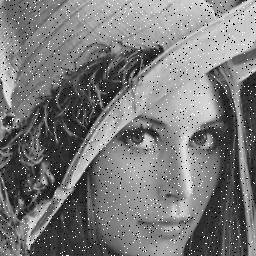

Imagen corregida:


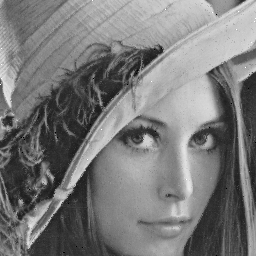

Imagen sin ruido exportada al archivo: Imagen2_sr.png


In [6]:
# para obtener el tiempo en el que se realiza el cálculo
start_time = time.time()

# cascarón de la imagen sin ruido (todos los valores son 0)
sub_imagen1=np.zeros((alto,ancho,3),dtype=int)

# recorriendo la imagen
for y in range(alto):
    for x in range(ancho):
        
        # si el pixel es una anomalía lo sustituye por el promedio, sino deja el pixel de la imágen original
        if [x,y] in anomalias_unicos:
            sub_imagen1[y,x] = df_posibles_anomalias[(df_posibles_anomalias['x']==x) & (df_posibles_anomalias['y']==y)]['media'].mean() 
        else:
            sub_imagen1[y,x] = pixeles[x,y][0] if caso==1 else pixeles[x,y]
imagen_sin_ruido = Image.fromarray(sub_imagen1.astype(np.uint8))

print('Corrección de anomalías tardó ',round((time.time()-start_time),2), ' segundos')
print('Imagen original:')
display(imagen_original)
print('Imagen corregida:')
display(imagen_sin_ruido)

# exporta la imagen sin ruido
print(f'Imagen sin ruido exportada al archivo: Imagen{numero_imagen}_sr.png')
imagen_sin_ruido.save(f'Imagen{numero_imagen}_sr.png')